# Credit Risk Assessment - Machine Learning Project

This notebook performs credit risk assessment using various machine learning algorithms.
The code has been refactored for simplicity and clarity.

## Project Overview
- **Dataset**: German Credit Dataset (1000 samples, 21 features)
- **Objective**: Predict creditworthiness of loan applicants
- **Approach**: Cost-sensitive classification with hyperparameter tuning
- **Models**: Random Forest, Decision Tree, Logistic Regression

## Notebook Structure
1. Data Loading and Preprocessing
2. Missing Value Imputation
3. Feature Engineering
4. Model Training and Evaluation
5. Results Visualization


In [ ]:
# Data analysis libraries
import numpy as np
import pandas as pd
from collections import Counter

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, make_scorer
from sklearn.metrics import RocCurveDisplay

# Machine learning libraries
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, f1_score, recall_score, roc_auc_score
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler

# Warnings handling
from warnings import simplefilter
import warnings

# Ignore warnings for cleaner output
simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

%matplotlib inline


In [ ]:
# Naming the columns as the name of the columns of the dataset are not given
feature_names = [
    'checking_account',      # A11-A14
    'duration_months',       # numerical
    'credit_history',        # A30-A34
    'purpose',              # A40-A410 (incomplete)
    'credit_amount',        # numerical
    'savings_account',      # A61-A65
    'employment_since',     # A71-A75 (incomplete)
    'installment_rate',     # numerical
    'personal_status',      # A91-A95
    'other_debtors',        # A101-A103
    'residence_since',      # numerical
    'property',             # A121-A124
    'age',                  # numerical
    'other_installments',   # A141-A143
    'housing',              # A151-A153
    'existing_credits',     # numerical
    'job',                  # A171-A175 (incomplete)
    'num_dependents',       # numerical
    'telephone',            # A191-A192
    'foreign_worker',       # A201-A202 (incomplete)
    'creditworthy'          # target: 1=yes, 2=no
]

# Reading the data in pandas as it's easy to process and manipulate
df = pd.read_csv('kredit.dat', header=None, sep="\t", names=feature_names)
# Display dataset shape


(1000, 21)

In [ ]:
# selecting target variable from the dataset and replacing 2 as 0 for the simplicity of the calculation
df.creditworthy.replace([1,2], [1,0], inplace=True)
label = df['creditworthy']
df_new = df.drop(columns=['creditworthy'])
df_new.shape

(1000, 20)

# Missing Value Analysis

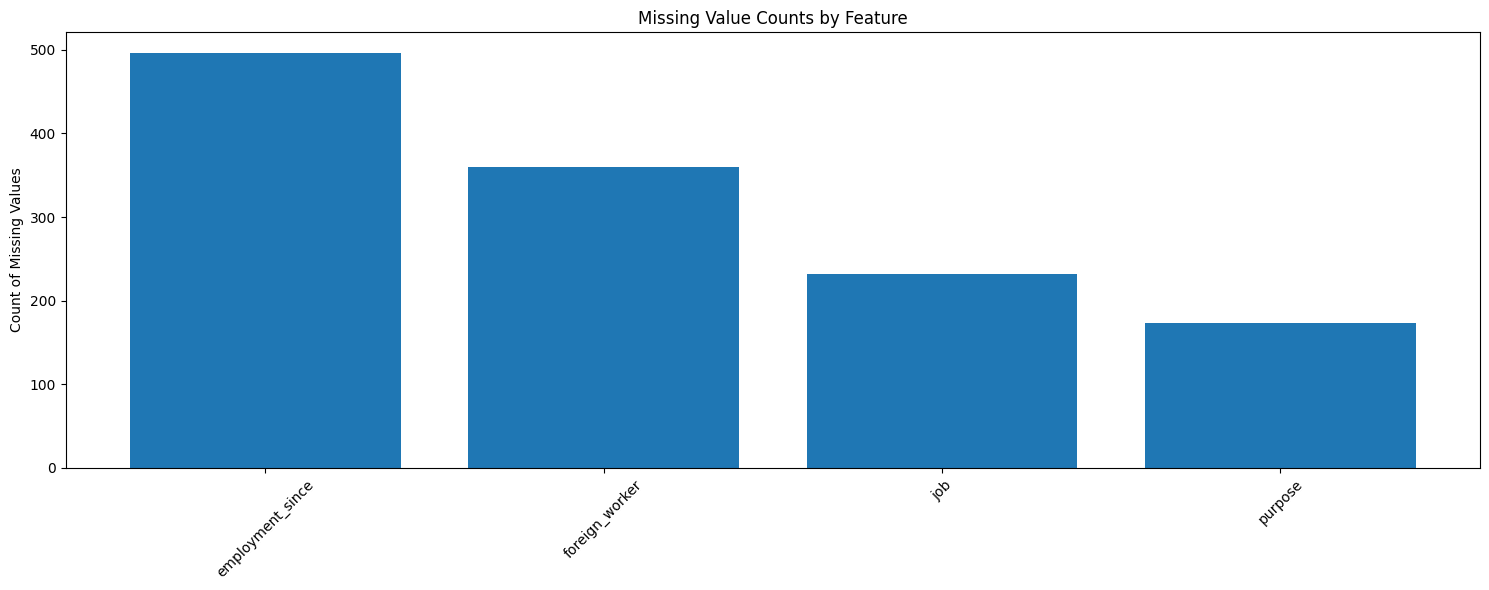

In [ ]:
# Identify missing values (marked as '?')
missing_analysis = pd.DataFrame({
    'Feature': df_new.columns,
    'Missing_Count': [sum(df_new[col] == '?') for col in df_new.columns],
    'Data_Type': df_new.dtypes
})

missing_analysis = missing_analysis.sort_values('Missing_Count', ascending=False)

# Visualize missing values
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 6))

# Missing value counts
missing_features = missing_analysis[missing_analysis['Missing_Count'] > 0]
ax1.bar(missing_features['Feature'], missing_features['Missing_Count'])
ax1.set_title('Missing Value Counts by Feature')
ax1.set_ylabel('Count of Missing Values')
ax1.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Handling missing values

Imputing missing values in order of least missing to most missing is often done for a few reasons:

More information for imputation: When you impute features with fewer missing values first, you are using more complete data to build the imputation model for those features. This can lead to more accurate predictions for the missing values in those features.


Building on imputed values: Once you have imputed the features with fewer missing values, you can then use these newly filled-in features as predictors when imputing features with more missing values. This provides the imputation model with a richer set of information, potentially improving the accuracy of those imputations as well.


Avoiding propagation of errors: If you were to impute features with many missing values first, the imputation model for those features would be based on data with many gaps. This could lead to less accurate imputations, and these inaccuracies could then be propagated when you use those features to impute others. Imputing in order helps to minimize this effect.

In [ ]:
def impute_missing_values(data):
    """
    Impute missing categorical values using Logistic Regression

    Parameters:
    -----------
    data : pd.DataFrame
        Input dataframe with missing values marked as '?'
    target_column : str
        Name of the target variable to exclude from predictors

    Returns:
    --------
    pd.DataFrame
        Dataframe with imputed missing values
    """

#  Create a copy to avoid modifying original data
    data_imputed = df_new.copy()

#  Step 1: Identify features with missing values and their order
#  Impute in order of least missing to most missing
#  Get missing features and their counts from the missing_features DataFrame
    missing_features_list = missing_features['Feature'].tolist()
    missing_counts = missing_features.set_index('Feature')['Missing_Count'].to_dict()

#  Step 2: Iterative imputation - impute one feature at a time
    for feature in missing_features_list:
        print(f"Imputing: {feature} ({missing_counts[feature]} missing values)")

#  Get complete cases for this feature
        complete_mask = data_imputed[feature] != '?'
        incomplete_mask = data_imputed[feature] == '?'

#  Prepare predictor features (all other features except current feature)
        predictor_features = [col for col in data_imputed.columns
                            if col not in [feature]]

#  Step 4: Prepare training data
        X_complete = data_imputed[complete_mask][predictor_features].copy()
        y_complete = data_imputed[complete_mask][feature].copy()
        X_missing = data_imputed[incomplete_mask][predictor_features].copy()

#  Step 5: Handle categorical variables in predictors
#  Replace any remaining '?' in predictors with mode (simple approach)
        for col in X_complete.columns:
            if X_complete[col].dtype == 'object':
                mode_val = X_complete[col].mode()[0] if not X_complete[col].mode().empty else 'unknown'
                X_complete[col] = X_complete[col].replace('?', mode_val)
                X_missing[col] = X_missing[col].replace('?', mode_val)

#  Step 6: Encode features for logistic regression
#  Create preprocessing pipeline
        categorical_predictors = [col for col in predictor_features
                                if data_imputed[col].dtype == 'object']
        numerical_predictors = [col for col in predictor_features
                              if data_imputed[col].dtype != 'object']

#  One-hot encode categorical predictors
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numerical_predictors),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
                 categorical_predictors)
            ])

#  Transform features
        X_complete_encoded = preprocessor.fit_transform(X_complete)
        X_missing_encoded = preprocessor.transform(X_missing)

#  Step 7: Train logistic regression model
#  Use multinomial for multi-class, balanced weights for class imbalance
        if len(np.unique(y_complete)) > 2:
            model = LogisticRegression(multi_class='multinomial',
                                     class_weight='balanced',
                                     random_state=42,
                                     max_iter=1000)
        else:
            model = LogisticRegression(class_weight='balanced',
                                     random_state=42,
                                     max_iter=1000)

#  Fit the model
        model.fit(X_complete_encoded, y_complete)

#  Step 9: Predict missing values
        y_predicted = model.predict(X_missing_encoded)

#  Get prediction probabilities for confidence assessment
        y_proba = model.predict_proba(X_missing_encoded)
        max_proba = np.max(y_proba, axis=1)

        print(f"  Average prediction confidence: {max_proba.mean():.3f}")
        print(f"  Low confidence predictions (<0.5): {(max_proba < 0.5).sum()}")

#  Step 10: Replace missing values
        data_imputed.loc[incomplete_mask, feature] = y_predicted

#  Show prediction distribution
        unique_predicted, counts = np.unique(y_predicted, return_counts=True)
        print(f"  Predicted value distribution:")
        for val, count in zip(unique_predicted, counts):
            print(f"    {val}: {count} ({count/len(y_predicted)*100:.1f}%)")

        print()

    return data_imputed

# Step 11: Apply imputation
data_imputed = impute_missing_values(df_new)

Imputing: employment_since (496 missing values)
  Average prediction confidence: 0.383
  Low confidence predictions (<0.5): 415
  Predicted value distribution:
    A71: 72 (14.5%)
    A72: 125 (25.2%)
    A73: 57 (11.5%)
    A74: 98 (19.8%)
    A75: 144 (29.0%)

Imputing: foreign_worker (360 missing values)
  Average prediction confidence: 0.885
  Low confidence predictions (<0.5): 0
  Predicted value distribution:
    A201: 298 (82.8%)
    A202: 62 (17.2%)

Imputing: job (232 missing values)
  Average prediction confidence: 0.568
  Low confidence predictions (<0.5): 90
  Predicted value distribution:
    A171: 18 (7.8%)
    A172: 76 (32.8%)
    A173: 84 (36.2%)
    A174: 54 (23.3%)

Imputing: purpose (173 missing values)
  Average prediction confidence: 0.233
  Low confidence predictions (<0.5): 170
  Predicted value distribution:
    A40: 14 (8.1%)
    A41: 22 (12.7%)
    A410: 11 (6.4%)
    A42: 13 (7.5%)
    A43: 15 (8.7%)
    A44: 43 (24.9%)
    A45: 6 (3.5%)
    A46: 9 (5.2%)
   

In [ ]:
def apply_binary_encoding(data):
    """
    Apply binary encoding to binary categorical features

    Parameters:
    -----------
    data : pd.DataFrame
        Input dataframe

    Returns:
    --------
    pd.DataFrame
        Dataframe with binary encoded features
    """

    data_binary = data.copy()

#  Phone: A191 (none) = 0, A192 (yes) = 1
    data_binary['has_phone'] = (data_binary['telephone'] == 'A192').astype(int)

#  Foreign worker: A201 (yes) = 1, A202 (no) = 0
    data_binary['is_foreign_worker'] = (data_binary['foreign_worker'] == 'A201').astype(int)

    return data_binary

In [ ]:
def apply_onehot_encoding(data):
    """
    Apply one-hot encoding to nominal categorical features

    Parameters:
    -----------
    data : pd.DataFrame
        Input dataframe

    Returns:
    --------
    pd.DataFrame
        Dataframe with one-hot encoded features
    """

    data_encoded = data.copy()

#  Features for one-hot encoding (removed phone and foreign_worker)
    onehot_features = [
        'purpose',
        'personal_status',
        'other_debtors',
        'property',
        'other_installments',
        'housing'
    ]

    for feature in onehot_features:
#  Get unique values for this feature
        unique_values = data_encoded[feature].unique()

#  Create binary columns for each unique value
        for value in unique_values:
            column_name = f"{feature}_{value}"
            data_encoded[column_name] = (data_encoded[feature] == value).astype(int)

    return data_encoded

In [ ]:
def apply_label_encoding(data):
    """
    Apply label encoding to ordinal categorical features

    Parameters:
    -----------
    data : pd.DataFrame
        Input dataframe with categorical features

    Returns:
    --------
    pd.DataFrame
        Dataframe with label encoded features
    """

    data_encoded = data.copy()

    checking_account_mapping = {
        'A11': 0,  # < 0 EUR (50.7% creditworthy - highest risk)
        'A12': 1,  # 0-200 EUR (61.0% creditworthy)
        'A13': 2,  # >= 200 EUR (77.8% creditworthy)
        'A14': 3   # no checking account (88.3% creditworthy - lowest risk!)
        }
    data_encoded['checking_account_encoded'] = data_encoded['checking_account'].map(checking_account_mapping)

    credit_history_mapping = {
        'A34': 0,  # critical account (worst)
        'A33': 1,  # delay in paying
        'A32': 2,  # existing credits paid duly
        'A31': 3,  # all credits at bank paid duly
        'A30': 4   # no credits/all paid duly (best)
        }
    data_encoded['credit_history_encoded'] = data_encoded['credit_history'].map(credit_history_mapping)

#  Savings Account: low to high savings
    savings_mapping = {
        'A61': 0,  # < 100 EUR (64.0% creditworthy - highest risk)
        'A62': 1,  # 100-500 EUR (67.0% creditworthy)
        'A63': 2,  # 500-1000 EUR (82.5% creditworthy)
        'A65': 3,  # unknown/no savings (82.5% creditworthy - good!)
        'A64': 4   # >= 1000 EUR (87.5% creditworthy - best)
        }
    data_encoded['savings_account_encoded'] = data_encoded['savings_account'].map(savings_mapping)

#  Employment Since: unemployed to long-term employment
    employment_mapping = {
        'A71': 0,  # unemployed (worst)
        'A72': 1,  # < 1 year
        'A73': 2,  # 1-4 years
        'A74': 3,  # 4-7 years
        'A75': 4   # >= 7 years (best)
        }
    data_encoded['employment_since_encoded'] = data_encoded['employment_since'].map(employment_mapping)

#  Job: skill level progression
    job_mapping = {
        'A171': 0,  # unemployed/unskilled non-resident (worst)
        'A172': 1,  # unskilled resident
        'A173': 2,  # skilled employee
        'A174': 3,  # management/self-employed
        'A175': 4   # highly qualified (best)
        }
    data_encoded['job_encoded'] = data_encoded['job'].map(job_mapping)

    return data_encoded

In [ ]:
def preprocess_categorical_features(data):
    """
    Apply complete categorical preprocessing pipeline
    """
#  Apply encoding in sequence
    data = apply_binary_encoding(data)
    data = apply_onehot_encoding(data)
    data = apply_label_encoding(data)
    
#  Remove original categorical columns that were encoded
    columns_to_drop = ['checking_account', 'credit_history', 'purpose', 
                      'savings_account', 'employment_since', 'personal_status',
                      'other_debtors', 'property', 'other_installments',
                      'housing', 'job', 'telephone', 'foreign_worker']
    
    data_processed = data.drop(columns=columns_to_drop, errors='ignore')
    print(f'Processed data shape: {data_processed.shape}')
    
    return data_processed


In [ ]:
# Apply the complete preprocessing pipeline
data_final = preprocess_categorical_features(data_imputed)

print(f"Original shape: {data_imputed.shape}")
print(f"Final shape: {data_final.shape}")
data_final.info()

Original shape: (1000, 20)
Final shape: (1000, 41)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   duration_months           1000 non-null   int64
 1   credit_amount             1000 non-null   int64
 2   installment_rate          1000 non-null   int64
 3   residence_since           1000 non-null   int64
 4   age                       1000 non-null   int64
 5   existing_credits          1000 non-null   int64
 6   num_dependents            1000 non-null   int64
 7   checking_account_encoded  1000 non-null   int64
 8   credit_history_encoded    1000 non-null   int64
 9   savings_account_encoded   1000 non-null   int64
 10  employment_since_encoded  1000 non-null   int64
 11  job_encoded               1000 non-null   int64
 12  has_phone                 1000 non-null   int64
 13  is_foreign_worker         1000 non-null   i

In [ ]:
def cost_sensitive_score(y_true, y_pred):
    """FP costs 5x more than FN"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    total_cost = fp * 5 + fn * 1
    return -total_cost  # Negative for sklearn maximization

In [ ]:
def nested_cross_validation(clf, param_grid, X, y, outer_splits=5, inner_splits=3):
    """
    Nested CV with cost-sensitive scoring for credit risk
    """
#  Create cost-sensitive scorer
    cost_scorer = make_scorer(cost_sensitive_score)

#  Define the outer cross-validation loop
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=42)

#  Store the scores for each fold
    outer_scores = {
        'cost': [],           # Our main metric (lower is better)
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': [],
        'fp_count': [],       # False Positive count
        'fn_count': []        # False Negative count
    }

    best_params_per_fold = []

#  Loop over each fold in the outer cross-validation
    for fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#  Inner cross-validation for hyperparameter tuning
        inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=43)
        grid_search = GridSearchCV(
            estimator=clf,
            param_grid=param_grid,
            cv=inner_cv,
            scoring=cost_scorer,  # Use cost-sensitive scoring
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

#  Store best params for this fold
        best_params_per_fold.append(grid_search.best_params_)

#  Get the best model from the inner CV
        best_model = grid_search.best_estimator_

#  Evaluate the best model on the outer test fold
        y_pred = best_model.predict(X_test)

#  Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        cost = fp * 5 + fn * 1

#  Calculate and store performance metrics
        outer_scores['cost'].append(cost)
        outer_scores['accuracy'].append(accuracy_score(y_test, y_pred))
        outer_scores['precision'].append(precision_score(y_test, y_pred))
        outer_scores['recall'].append(recall_score(y_test, y_pred))
        outer_scores['f1'].append(f1_score(y_test, y_pred))
        outer_scores['roc_auc'].append(roc_auc_score(y_test, y_pred))
        outer_scores['fp_count'].append(fp)
        outer_scores['fn_count'].append(fn)

        print(f"Fold {fold_idx+1}: Cost={cost}, FP={fp}, FN={fn}, Params={grid_search.best_params_}")

#  Calculate mean and standard deviation for each metric
    results = {metric: {'mean': np.mean(scores), 'std': np.std(scores)}
              for metric, scores in outer_scores.items()}

#  Display the results
    print(f"\nNested CV Results:")
    print("-" * 50)
    for metric, scores in results.items():
        print(f"{metric.capitalize()} - Mean: {scores['mean']:.4f}, Std: {scores['std']:.4f}")

#  Find most common parameters across folds
    common_params = {}
    for param_name in param_grid.keys():
        param_values = [params[param_name] for params in best_params_per_fold]
        most_common = Counter(param_values).most_common(1)[0][0]
        common_params[param_name] = most_common

    print(f"\nMost common parameters across folds: {common_params}")

    return results, common_params, best_params_per_fold

In [ ]:
def hyperparameter_tuning(model_class, param_grid, features, labels, model_name):
    """
    Generic hyperparameter tuning function for any sklearn classifier
    
    Parameters:
    -----------
    model_class : sklearn estimator class
        The classifier class (e.g., RandomForestClassifier, DecisionTreeClassifier)
    param_grid : dict
        Hyperparameter grid for GridSearchCV
    features : DataFrame or array
        Training features
    labels : Series or array
        Training labels
    model_name : str
        Name of the model for logging
        
    Returns:
    --------
    results : dict
        Cross-validation results
    best_params : dict
        Best hyperparameters found
    all_params : list
        All parameter combinations tried
    """
    print(f'Starting {model_name} hyperparameter tuning...')
    
#  Use the existing nested cross validation function
    clf = model_class()
    results, best_params, all_params = nested_cross_validation(
        clf, param_grid, features, labels
    )
    
    print(f'{model_name} hyperparameter tuning completed.')
    return results, best_params, all_params


### Random Forest Hyperparameter Tuning

Execute hyperparameter tuning for Random Forest using the generic function.


In [ ]:
def evaluate_final_model(model_class, best_params, X, y, model_name, test_size=0.2, random_state=42):
    """
    Evaluation function for final model

    Parameters:
    -----------
    model_class : sklearn estimator class
        The model class (e.g., RandomForestClassifier, DecisionTreeClassifier)
    best_params : dict
        Best parameters from hyperparameter tuning
    X : DataFrame
        Features
    y : Series
        Target variable
    model_name : str
        Name of the model for display purposes
    test_size : float
        Proportion for test split
    random_state : int
        Random state for reproducibility

    Returns:
    --------
    final_model : trained model
        The final trained model
    final_cost : float
        Final cost on test set
    """
    print(f"\n{'='*60}")
    print(f"FINAL {model_name.upper()} MODEL EVALUATION")
    print(f"{'='*60}")

#  Split data for final evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    print(f"Training set size: {X_train.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")
    print(f"Best parameters: {best_params}")

#  Create and train final model
    final_model = model_class(**best_params)
    final_model.fit(X_train, y_train)

#  Make predictions
    y_pred = final_model.predict(X_test)

#  Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    final_cost = fp * 5 + fn * 1

#  Calculate rates
    FPR = (fp / (fp + tn)) * 100
    FNR = (fn / (tp + fn)) * 100

#  Print results
    print(f"\n{model_name} Performance Results:")
    print("-" * 50)
    print(f"Total Cost: {final_cost}")
    print(f"  - False Positive Cost: {fp} × 5 = {fp * 5}")
    print(f"  - False Negative Cost: {fn} × 1 = {fn * 1}")
    print()
    print(f"Standard Metrics:")
    print(f"  - Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"  - Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"  - Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"  - F1-Score:  {f1_score(y_test, y_pred):.4f}")
    print(f"  - ROC-AUC:   {roc_auc_score(y_test, y_pred):.4f}")

#  Visualize Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=final_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)

    disp.plot()
    plt.show()

    return final_model, final_cost


FINAL RANDOM FOREST MODEL EVALUATION
Training set size: 800
Test set size: 200
Best parameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'class_weight': 'balanced', 'random_state': 42}

Random Forest Performance Results:
--------------------------------------------------
Total Cost: 132
  - False Positive Cost: 19 × 5 = 95
  - False Negative Cost: 37 × 1 = 37

Confusion Matrix Components:
  - True Negatives (TN):  41
  - False Positives (FP): 19
  - False Negatives (FN): 37
  - True Positives (TP):  103

Error Rates:
  - False Positive Rate: 31.67%
  - False Negative Rate: 26.43%

Standard Metrics:
  - Accuracy:  0.7200
  - Precision: 0.8443
  - Recall:    0.7357
  - F1-Score:  0.7863
  - ROC-AUC:   0.7095


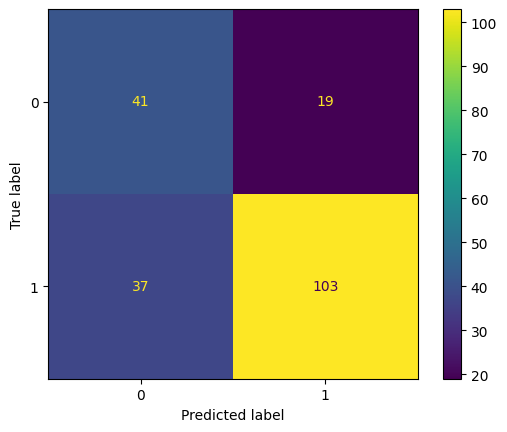

In [ ]:
rf_final_model, rf_final_cost = evaluate_final_model(
    model_class=RandomForestClassifier,
    best_params=rf_best_params,
    X=data_final,
    y=label,
    model_name="Random Forest"
)

In [ ]:
# This cell was consolidated into the generic hyperparameter_tuning function


In [ ]:
# For Decision Tree
dt_results, dt_best_params, dt_all_params = hyperParameterTuning_DecisionTree(data_final, label)

Starting Cost-Sensitive Decision Tree Nested Cross-Validation...
Dataset shape: (1000, 41)
Class distribution: {1: 700, 0: 300}
Fold 1: Cost=159, FP=22, FN=49, Params={'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'random_state': 42}
Fold 2: Cost=109, FP=11, FN=54, Params={'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'random_state': 42}
Fold 3: Cost=153, FP=24, FN=33, Params={'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'random_state': 42}
Fold 4: Cost=118, FP=12, FN=58, Params={'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 20, 'random_state': 42}
Fold 5: Cost=147, FP=19, FN=52, Params={'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'random_state': 42}

Ne


FINAL DECISION TREE MODEL EVALUATION
Training set size: 800
Test set size: 200
Best parameters: {'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 10, 'criterion': 'gini', 'class_weight': 'balanced', 'random_state': 42}

Decision Tree Performance Results:
--------------------------------------------------
Total Cost: 131
  - False Positive Cost: 13 × 5 = 65
  - False Negative Cost: 66 × 1 = 66

Confusion Matrix Components:
  - True Negatives (TN):  47
  - False Positives (FP): 13
  - False Negatives (FN): 66
  - True Positives (TP):  74

Error Rates:
  - False Positive Rate: 21.67%
  - False Negative Rate: 47.14%

Standard Metrics:
  - Accuracy:  0.6050
  - Precision: 0.8506
  - Recall:    0.5286
  - F1-Score:  0.6520
  - ROC-AUC:   0.6560


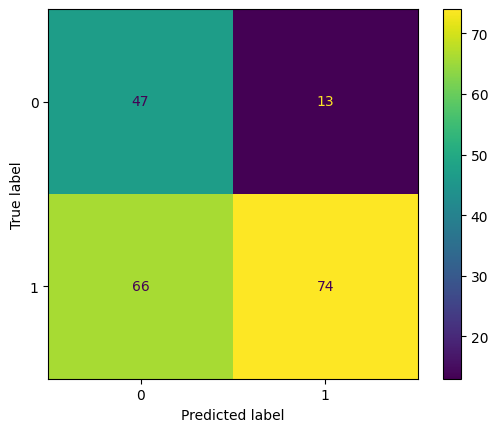

In [ ]:
dt_final_model, dt_final_cost = evaluate_final_model(
    model_class=DecisionTreeClassifier,
    best_params=dt_best_params,
    X=data_final,
    y=label,
    model_name="Decision Tree"
)

In [ ]:
def prepare_data_for_logistic_regression(X):
    """
    Scale only numerical features, leave encoded categoricals unchanged
    """
    print("Preparing data for Logistic Regression...")
    print(f"Original data shape: {X.shape}")

#  Define numerical features (need scaling)
    numerical_features = [
        'duration_months', 'credit_amount', 'installment_rate',
        'residence_since', 'age', 'existing_credits', 'num_dependents'
    ]

#  Define encoded categorical features (already 0/1, DON'T scale)
    encoded_categorical_features = [col for col in X.columns if col not in numerical_features]

    print(f"Numerical features to scale ({len(numerical_features)}): {numerical_features}")
    print(f"Encoded categorical features to keep unchanged ({len(encoded_categorical_features)}): {len(encoded_categorical_features)} features")

#  Create preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', StandardScaler(), numerical_features),
            ('categorical', 'passthrough', encoded_categorical_features)
        ],
        remainder='drop'
    )

#  Transform data
    X_processed = preprocessor.fit_transform(X)

#  Convert back to DataFrame
    feature_names = numerical_features + encoded_categorical_features
    X_processed_df = pd.DataFrame(
        X_processed,
        columns=feature_names,
        index=X.index
    )

    print(f"Processed data shape: {X_processed_df.shape}")

    return X_processed_df

In [ ]:
# This cell was consolidated into the generic hyperparameter_tuning function


In [ ]:
# Step 1: Prepare scaled data
data_scaled = prepare_data_for_logistic_regression(data_final)

Preparing data for Logistic Regression...
Original data shape: (1000, 41)
Numerical features to scale (7): ['duration_months', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_dependents']
Encoded categorical features to keep unchanged (34): 34 features
Processed data shape: (1000, 41)


In [ ]:
# Step 2: Hyperparameter tuning
lr_results, lr_best_params, lr_all_params = hyperParameterTuning_LogisticRegression(data_scaled, label)

Starting Cost-Sensitive Logistic Regression Nested Cross-Validation...
Dataset shape: (1000, 41)
Class distribution: {1: 700, 0: 300}
Fold 1: Cost=138, FP=19, FN=43, Params={'C': 0.001, 'class_weight': 'balanced', 'max_iter': 1000, 'random_state': 42, 'solver': 'lbfgs'}
Fold 2: Cost=127, FP=18, FN=37, Params={'C': 0.001, 'class_weight': 'balanced', 'max_iter': 1000, 'random_state': 42, 'solver': 'lbfgs'}
Fold 3: Cost=155, FP=23, FN=40, Params={'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'random_state': 42, 'solver': 'liblinear'}
Fold 4: Cost=106, FP=13, FN=41, Params={'C': 0.1, 'class_weight': 'balanced', 'max_iter': 1000, 'random_state': 42, 'solver': 'liblinear'}
Fold 5: Cost=118, FP=14, FN=48, Params={'C': 0.001, 'class_weight': 'balanced', 'max_iter': 1000, 'random_state': 42, 'solver': 'lbfgs'}

Nested CV Results:
--------------------------------------------------
Cost - Mean: 128.8000, Std: 16.7976
Accuracy - Mean: 0.7040, Std: 0.0193
Precision - Mean: 0.8505, Std: 0.


FINAL LOGISTIC REGRESSION MODEL EVALUATION
Training set size: 800
Test set size: 200
Best parameters: {'C': 0.001, 'solver': 'lbfgs', 'max_iter': 1000, 'class_weight': 'balanced', 'random_state': 42}

Logistic Regression Performance Results:
--------------------------------------------------
Total Cost: 125
  - False Positive Cost: 16 × 5 = 80
  - False Negative Cost: 45 × 1 = 45

Confusion Matrix Components:
  - True Negatives (TN):  44
  - False Positives (FP): 16
  - False Negatives (FN): 45
  - True Positives (TP):  95

Error Rates:
  - False Positive Rate: 26.67%
  - False Negative Rate: 32.14%

Standard Metrics:
  - Accuracy:  0.6950
  - Precision: 0.8559
  - Recall:    0.6786
  - F1-Score:  0.7570
  - ROC-AUC:   0.7060


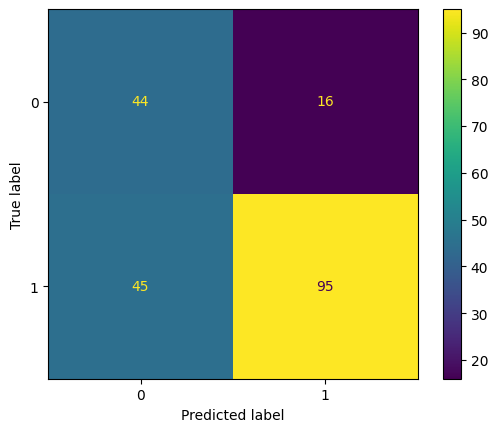

In [ ]:
# Step 3: Final evaluation
lr_final_model, lr_final_cost = evaluate_final_model(
    model_class=LogisticRegression,
    best_params=lr_best_params,
    X=data_scaled,
    y=label_scaled,
    model_name="Logistic Regression"
)

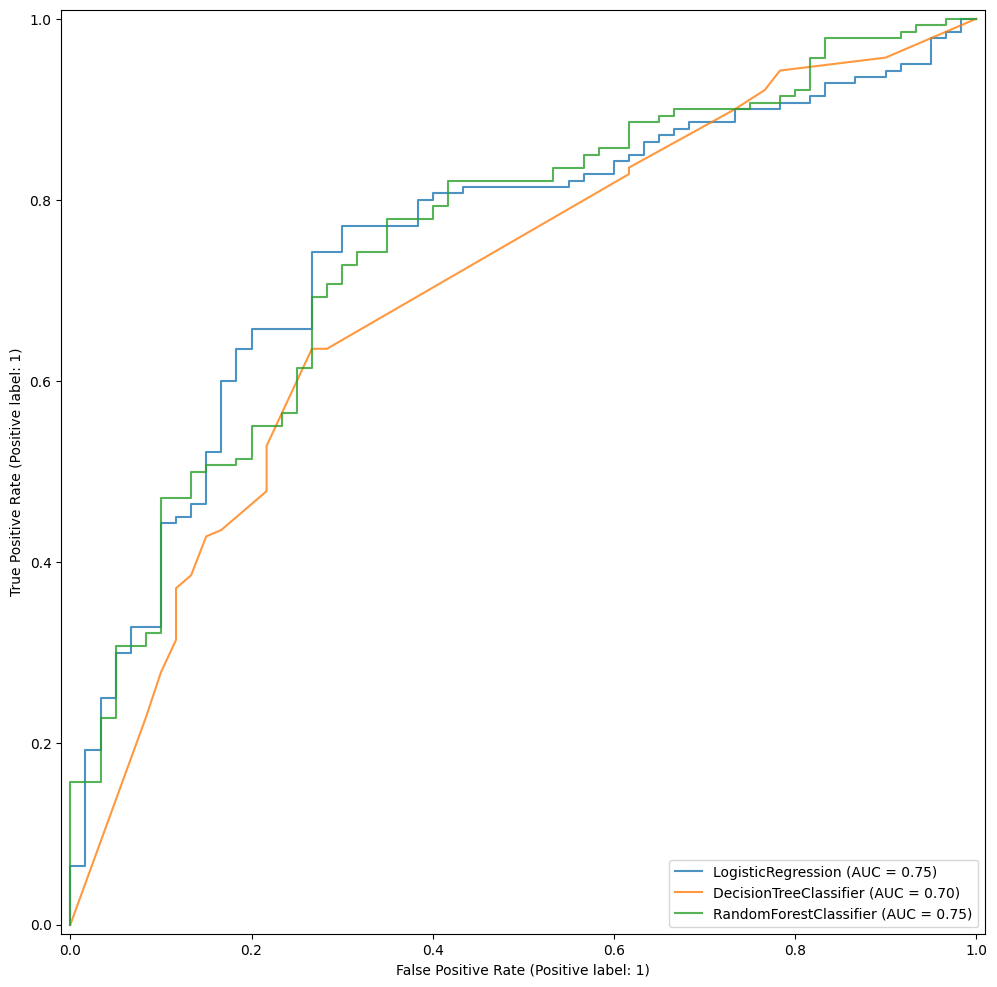

In [ ]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    data_scaled, label, test_size=0.2, stratify=label, random_state=42
)

ax = plt.gca()

clf_lr_disp = RocCurveDisplay.from_estimator(lr_final_model, X_test_scaled, y_test_scaled, ax=ax,alpha=0.8)
clf_tree_disp = RocCurveDisplay.from_estimator(dt_final_model, X_test, y_test, ax=ax,alpha=0.8)
clf_rf_disp = RocCurveDisplay.from_estimator(rf_final_model, X_test, y_test, ax=ax,alpha=0.8)

ax.figure.set_size_inches(20, 12)
plt.show()

Preparing data for Logistic Regression...
Original data shape: (1000, 41)
Numerical features to scale (7): ['duration_months', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_dependents']
Encoded categorical features to keep unchanged (34): 34 features
Processed data shape: (1000, 41)


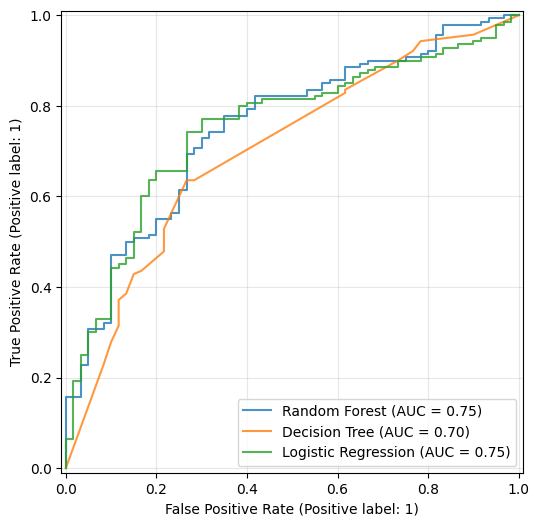

In [ ]:
# Make sure to prepare the scaled data first
data_scaled = prepare_data_for_logistic_regression(data_final)

# Create consistent splits
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    data_final, label, test_size=0.2, stratify=label, random_state=42
)

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    data_scaled, label, test_size=0.2, stratify=label, random_state=42
)

# Train your models using the SAME splits
rf_final_model = RandomForestClassifier(**rf_best_params)
rf_final_model.fit(X_train_orig, y_train_orig)

dt_final_model = DecisionTreeClassifier(**dt_best_params)
dt_final_model.fit(X_train_orig, y_train_orig)

lr_final_model = LogisticRegression(**lr_best_params)
lr_final_model.fit(X_train_scaled, y_train_scaled)

# NOW your ROC plot will be consistent:
ax = plt.gca()

clf_rf_disp = RocCurveDisplay.from_estimator(rf_final_model, X_test_orig, y_test_orig, ax=ax, alpha=0.8, name='Random Forest')
clf_dt_disp = RocCurveDisplay.from_estimator(dt_final_model, X_test_orig, y_test_orig, ax=ax, alpha=0.8, name='Decision Tree')
clf_lr_disp = RocCurveDisplay.from_estimator(lr_final_model, X_test_scaled, y_test_scaled, ax=ax, alpha=0.8, name='Logistic Regression')

ax.figure.set_size_inches(10, 6)
ax.grid(True, alpha=0.3)
plt.show()